In [1]:
#Import packages
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer.pitch import Pitch, VerticalPitch
import seaborn as sns
import ipywidgets as widgets
from highlight_text import  ax_text, fig_text
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import warnings

#Read data
df = pd.read_csv('Footballdata/UCL/Final.csv', encoding='latin-1')

#Change Offside Passes to Passes
df = df.replace('OffsidePass', 'Pass')

#Adjust to pitch
df['x'] = df['x']*1.2
df['y'] = df['y']*.8
df['endX'] = df['endX']*1.2
df['endY'] = df['endY']*.8

#Replacing NaN values
df.endX.fillna(df.x, inplace=True)
df.endY.fillna(df.y, inplace=True)

#remove substitution events,challenges & formation change
df = df.loc[~(df['type/displayName'] == 'SubstitutionOff')]
df = df.loc[~(df['type/displayName'] == 'SubstitutionOn')]
df = df.loc[~(df['type/displayName'] == 'FormationChange')]
df = df.loc[~(df['type/displayName'] == 'Challenge')]
df = df.loc[~(df['type/displayName'] == 'FormationSet')]
df = df.loc[~(df['type/displayName'] == 'Start')]
df = df.loc[~(df['type/displayName'] == 'End')]
df = df.loc[~(df['type/displayName'] == 'Aerial')]
df = df.loc[~(df['type/displayName'] == 'Tackle')]

#remove the records of a failed foul, they should be ignored as their challenges are failed and the shot continues
df = df.loc[~((df['type/displayName'] == 'Foul') & (df['outcomeType/displayName'] == 'Unsuccessful'))]

#remove the records of a corners awarded, they should be ignored as their challenges are failed and the shot continues
df = df.loc[~((df['type/displayName'] == 'CornerAwarded') & (df['outcomeType/displayName'] == 'Unsuccessful'))]

In [2]:
#Filter for ball touches and whether it is a ball recovery
actions = df.loc[(df['isTouch'] == True)
                |(df['type/displayName'] == 'BallRecovery')]

#Taking the variables that are needed
actions = actions[['expandedMinute', 'teamId','type/displayName','outcomeType/displayName','playername',
                   'x', 'y', 'endX', 'endY']]

#finding the Recipient of the action/pass made
actions['Recipient'] = actions['playername'].shift(-1)

#finding the next event that occured along with the x & y positions
actions['nextEvent'] = actions['type/displayName'].shift(-1)
actions['x_next'] = actions['x'].shift(-1)
actions['y_next'] = actions['y'].shift(-1)
actions['outcomeType_next'] = actions['outcomeType/displayName'].shift(-1)

#find if the next event is by the same team
actions['teamId_next'] = actions['teamId'].shift(-1)

actions = actions.loc[ (actions['nextEvent'] == 'Pass')
                      |(actions['nextEvent'] == 'TakeOn')
                      |(actions['nextEvent'] == 'Dispossessed')
                      |(actions['nextEvent'] == 'BallRecovery')
                      |(actions['nextEvent'] == 'MissedShots')
                      |(actions['nextEvent'] == 'ShotOnPost')
                      |(actions['nextEvent'] == 'Goal')
                      |(actions['nextEvent'] == 'GoodSkill')
                      |(actions['nextEvent'] == 'SavedShot')
                      |(actions['nextEvent'] == 'BallTouch')
                      |((actions['nextEvent'] == 'Foul') & (actions['outcomeType_next'] == 'Successful'))
                      |((actions['nextEvent'] == 'CornerAwarded') & (actions['outcomeType_next'] == 'Successful'))]

#to calculate the distance between the carried distance, using Euclidean formula
#needs to be more than or equals to a certain value
min_dribble_length = 4
far_enough = (actions['x_next']-actions['endX'])**2 + (actions['y_next'] -actions['endY'])**2 >= min_dribble_length**2

#Check if next team is the same team
same_team = actions['teamId'] == actions['teamId_next']

#filter to find the carries
carries = actions[(far_enough) & (same_team)]

#Reset Index
carries = carries.reset_index(drop=True)

#Filter for carries that starts before the final third and arrives in the final third
F3rd_carries = carries.loc[(carries['endX'] < 80) & (carries['x_next'] >= 80)]

In [3]:
#List of Carries
carries_list = carries.groupby(['Recipient','teamId']).size().reset_index().rename(columns={0:'Total Carries'}).sort_values('Recipient', ascending = False).reset_index()
del carries_list['index']

#List of Carries
F3rd_carries_list = F3rd_carries.groupby(['Recipient','teamId']).size().reset_index().rename(columns={0:'Carries into Final Third'}).sort_values('Recipient', ascending = False).reset_index()
del F3rd_carries_list['index']

#Merge the two lists
carrylist = pd.merge(carries_list, F3rd_carries_list, on="Recipient")
carrylist = carrylist.drop(['teamId_y'], axis = 1)
carrylist.rename(columns = {'teamId_x':'Team', 'Recipient':'Player'},inplace = True)
carrylist = carrylist.sort_values('Carries into Final Third', ascending= False).reset_index(drop = True)
carrylist.index += 1
carrylist.head(15)

,Player,Team,Total Carries,Carries into Final Third
1,Sadio Mané,Liverpool,27,5
2,Fabinho,Liverpool,39,4
3,Vinícius Júnior,Real Madrid,25,3
4,Trent Alexander-Arnold,Liverpool,24,2
5,Toni Kroos,Real Madrid,33,2
6,Naby Keïta,Liverpool,13,2
7,Federico Valverde,Real Madrid,12,2
8,Daniel Carvajal,Real Madrid,26,2
9,Thiago,Liverpool,22,1
10,Mohamed Salah,Liverpool,26,1


In [4]:
#List it in a combo box
options = df["playername"].unique()
options = options.tolist()

options = [x for x in options if str(x) != 'nan']
playerlist = widgets.Combobox(
    placeholder='Enter a name',
    options=options,
    description='Player:',
    ensure_option=True,
    disabled=False
)
playerlist

Combobox(value='', description='Player:', ensure_option=True, options=('Jordan Henderson', 'Ibrahima Konaté', …

In [5]:
#Retrieve player
player = playerlist.value

#Filter for player
F3rd_carries = F3rd_carries.loc[F3rd_carries['Recipient'] == player]

#Filter for player (carries)
carries = carries.loc[carries['Recipient'] == player]

carry = len(F3rd_carries.index)

#Retrieve team name from the carries
team = carries['teamId'].unique()
team = team[0]

#Retrieve Opposition team
oppo = df.loc[(df['teamId']!= team)]
oppo = oppo['teamId'].unique()
oppo = oppo[0]

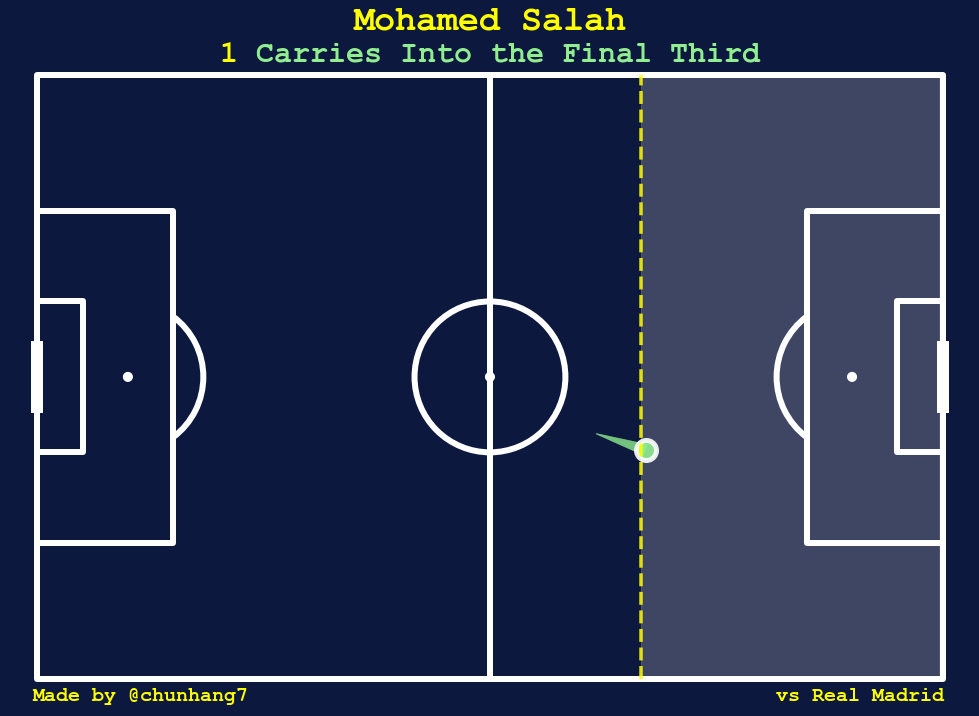

In [6]:
#Make the pitch
pitch = Pitch(pitch_type='statsbomb', pitch_color='#0d183f', line_color='white',linewidth=6, spot_scale=0.005)
fig, ax = pitch.draw(figsize=(14, 11), constrained_layout=False, tight_layout=True)
fig.set_facecolor('#0d183f')

#Inverse y-axis
plt.gca().invert_yaxis()

#Draw line
ax.plot([80,80], [0, 80], c='yellow', lw=3.5, ls='--', zorder=9, alpha=0.85)
"""
#plot carries (lines)
pitch.lines(carries.endX,carries.endY,carries.x_next,carries.y_next,
            ax=ax,comet = True, linewidth=10, capstyle='round', zorder=2,
            alpha=0.06, color ='#aacfec')

pitch.scatter(carries['x_next'], carries['y_next'],
              edgecolors= "#aacfec", c="#aacfec", s = 150, zorder=2, ax=ax, 
              marker = 'o', alpha = 0.07,linewidths=3)"""

#plot progressive carries (lines)
pitch.lines(F3rd_carries.endX, F3rd_carries.endY, F3rd_carries.x_next, F3rd_carries.y_next,
            ax=ax,comet = True, color= 'lightgreen', lw=12, alpha = 0.6)

pitch.scatter(F3rd_carries.x_next, F3rd_carries.y_next, edgecolors= 'w', c='lightgreen',
              s = 400, zorder=4, ax=ax, marker = 'o', alpha = 0.9,linewidths=5)

#shade
plt.axvspan(80,119.5,ymin=0.05,ymax=0.96,color='lightgrey',zorder=-1,alpha=0.25)

#Title & Annotations
fig.suptitle(player + "\n\n", fontsize=35, color='yellow',
            fontfamily = "Courier New", fontweight = "bold",x=0.5,y=0.9)

highlight_textprops =\
    [{"color": "lightgreen","fontweight": 'bold'}]

Title = fig_text(s = str(carry) + " <Carries Into the Final Third>",
        x = 0.5, y = 0.855, highlight_textprops = highlight_textprops ,color='yellow',
        fontfamily = "Courier New",fontweight='bold', ha='center',fontsize=30);

#Annotations
fig.text(0.26, 0.03,'Made by @chunhang7', fontsize=20, color='yellow', fontweight = 'bold', 
         fontfamily = 'Courier New',ha='right', va='center')

fig.text(0.95, 0.03,'vs ' + oppo, fontsize=20, color='yellow', fontweight = 'bold', 
         fontfamily = 'Courier New',ha='right', va='center')

plt.show()